In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../data/feat_eng_train1.csv')
test = pd.read_csv('../data/feat_eng_test1.csv')

In [4]:
X = train.drop('tumor_size', axis=1)
y = train['tumor_size']

In [5]:
def cross_validate(model, X, y, n_folds=10):
    scores = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1234)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                  verbose=0, early_stopping_rounds=300, eval_metric='rmse')
#         model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], use_best_model=True)

        preds = model.predict(valid_x)
#         t_preds = tt.inverse_transform(preds.reshape(-1, 1)).ravel()
        score = np.sqrt(mean_squared_error(valid_y, preds))
        
        scores.append(score)
        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

In [33]:
def get_kfold_prediction(model, X, y, test_data, n_folds=10):
    scores = []
    oof_preds = np.zeros(test_data.shape[0])
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1234)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

#         model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], use_best_model=True)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], 
                  verbose=0, early_stopping_rounds=300, eval_metric='rmse')

        preds = model.predict(valid_x)
#         t_preds = tt.inverse_transform(preds.reshape(-1, 1)).ravel()

        # change metric according to requirement
        score = np.sqrt(mean_squared_error(valid_y, preds))
        scores.append(score)

        # change this according to requirement
        oof_preds += model.predict(test_data) / n_folds

        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

    return oof_preds

In [6]:
# change the objective

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 2000,
    'max_depth': 7,
    'learning_rate': 0.05,
    'gamma': 10,
    'min_child_weight': 0.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    # 'colsample_bylevel': 0.4,
    # 'colsample_bynode': 0.6,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    # 'scale_pos_weight': 4,
    # 'importance_type': 'gain',
    # 'max_delta_step': ,
    # 'base_score': ,
    # 'tree_method': 'auto',
    # 'missing': ,
    # 'num_parallel_tree': ,
    # 'monotone_constraints': ,
    # 'interaction_constraints': ,
    'n_jobs': -1,
    'random_state': 1234,
    'verbosity': 0,
}

In [7]:
xgb_model = xgb.XGBRegressor(**xgb_params)

In [8]:
cross_validate(xgb_model, X, y, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 3.883334
Fold 2: 4.091490
Fold 3: 4.017224
Fold 4: 4.017724
Fold 5: 4.030924
Fold 6: 4.212515
Fold 7: 4.099617
Fold 8: 4.115370
Fold 9: 3.818520
Fold 10: 4.230243
Mean Score: 4.051696099773077


In [9]:
xgb_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=0.4, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=-1, num_parallel_tree=1,
             random_state=1234, reg_alpha=0.01, reg_lambda=0.5,
             scale_pos_weight=1, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [14]:
X

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,exp(damage_size),...,Abs(malign_penalty)/malign_penalty,Abs(err_malign),err_malign*malign_ratio,damage_size**2*Abs(malign_ratio),malign_penalty**3*Abs(err_malign),damage_ratio*exposed_area**2,size_npear*exp(malign_ratio),Abs(malign_ratio)/malign_ratio,malign_ratio**2*exp(damage_size),exp(damage_ratio)*exp(size_npear)
0,-0.688271,0.150536,1.801721,-1.117626,-0.619398,-0.368977,-0.964623,0.345142,0.807538,0.327055,...,1.0,0.964623,-1.737981,2.250508,0.039660,0.309816,0.912261,1.0,1.061687,2.606673
1,1.348315,1.252353,0.192869,1.716044,1.229464,1.376569,1.414469,2.094171,-1.868851,5.562477,...,1.0,1.414469,0.272807,0.567961,12.990611,-2.824921,1.518758,1.0,0.206915,0.539831
2,0.349871,-0.081906,-0.791991,0.684628,0.319116,0.456767,0.633297,0.362952,-0.821343,1.983034,...,1.0,0.633297,-0.501565,0.371218,0.030280,-0.083642,-0.037099,-1.0,1.243856,0.405251
3,0.923094,1.081385,0.692788,1.058498,0.908190,0.621616,1.035512,-0.619613,-1.093747,2.882039,...,-1.0,1.035512,0.717390,0.776213,-0.246330,-0.902131,2.161994,1.0,1.383250,0.987715
4,-0.465060,0.123852,1.248519,-0.099043,-0.482686,-0.087708,-0.450706,0.050792,-0.001150,0.905704,...,1.0,0.450706,-0.562715,0.012247,0.000059,-0.000268,0.431647,1.0,1.411810,1.130547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,-0.569553,0.291878,1.928772,-0.172751,-0.643363,-0.189448,-0.351735,-0.038111,0.360958,0.841347,...,-1.0,0.351735,-0.678417,0.057560,-0.000019,0.149406,2.008430,1.0,3.129946,1.920982
9049,0.293380,0.563212,0.767917,0.014736,0.210867,0.374250,0.884965,-0.689687,-0.658556,1.014845,...,-1.0,0.884965,0.679579,0.000167,-0.290323,-0.029282,1.213876,1.0,0.598450,0.909060
9050,-0.284974,-1.069571,-1.697011,-0.261039,-0.273391,-0.477059,0.021890,-1.512917,-0.130792,0.770251,...,-1.0,0.021890,-0.037148,0.115636,-0.075805,-0.009776,-0.195978,-1.0,2.218205,0.301085
9051,1.155406,1.838692,2.086468,-0.123980,1.099978,1.356517,5.283015,-0.398802,-0.076460,0.883398,...,-1.0,5.283015,11.022840,0.032071,-0.335085,-0.092513,14.813253,1.0,3.845738,5.825423


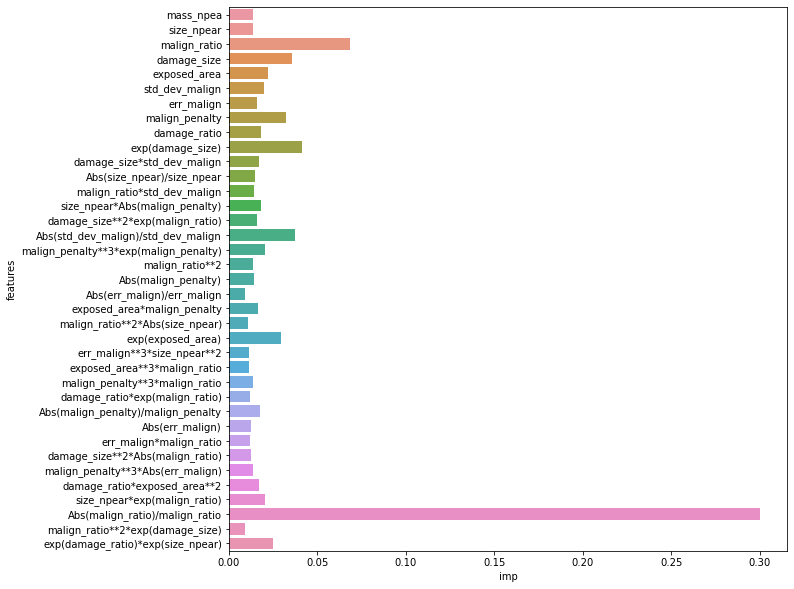

In [18]:
xgb_feat_imp = pd.DataFrame({
    'features': X.columns.tolist(),
    'imp': xgb_model.feature_importances_
})

plt.figure(figsize=(10, 10))
sns.barplot(data=xgb_feat_imp, x='imp', y='features')
plt.show()

In [19]:
# change the objective and metric

lgb_params = {
    'metric': 'rmse',
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'n_estimators': 30000,
    'learning_rate': 0.0005,
    'max_depth': 7,
    'num_leaves': 64,  
    'max_bin': 512,
    'min_child_samples': 32,
    'subsample': 0.75,
#     'bagging_freq': 10,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    'early_stopping_round': 300,
    # 'categorical_feature': '',
    # 'min_child_weight': 0.01,
    # 'colsample_bytree': 0.8,
    # 'colsample_bynode': 0.8,
    # 'random_strength': 2,
    # 'one_hot_max_size': 4,
    'verbose': -1,
    'seed': 1234,
    'n_jobs': -1,
}

In [20]:
lgb_model = lgb.LGBMRegressor(**lgb_params)

In [21]:
cross_validate(lgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 3.964724
Fold 2: 4.253579
Fold 3: 4.181327
Fold 4: 4.107891
Fold 5: 4.113327
Fold 6: 4.402832
Fold 7: 4.280788
Fold 8: 4.279742
Fold 9: 3.931800
Fold 10: 4.312258
Mean Score: 4.182826825336278
